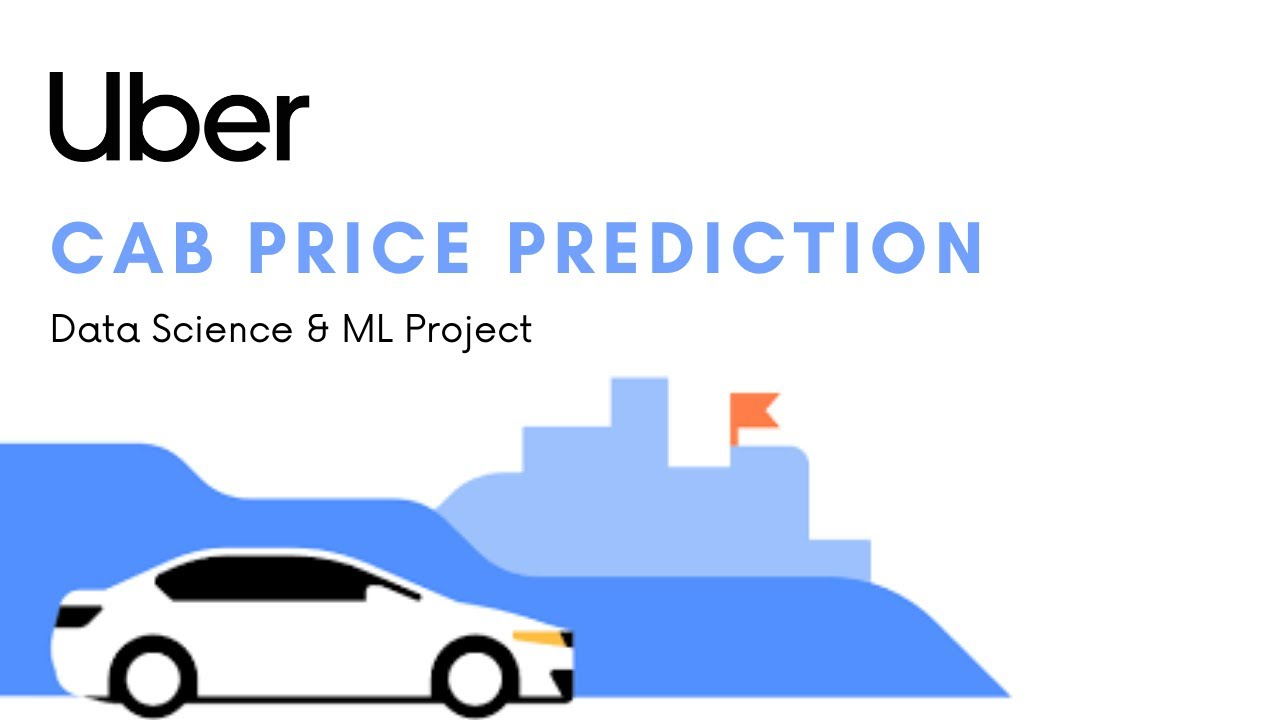

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
import pandas as pd
from geopy.distance import geodesic
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [6]:
data = pd.read_csv('uber.csv')

In [7]:
np.shape(data)

(200000, 9)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [9]:
data.head(5)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [10]:
data.drop('Unnamed: 0', axis = 1, inplace = True)

Data Pre-Processing

In [11]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [12]:
missing_values = data.isnull()
total_count = missing_values.sum()
total_count

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [13]:
data.dropna(inplace = True)

In [14]:
data.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [15]:
#Converting the datetime to pandas datetime type
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

#Dividing into the columns:
data['year'] = data['pickup_datetime'].dt.year
data['Month'] = data['pickup_datetime'].dt.month
data['Day'] = data['pickup_datetime'].dt.day
data['week_day'] = data['pickup_datetime'].dt.dayofweek

data['hour'] = data['pickup_datetime'].dt.hour

#categorizing the time of the day:
def category(hour):
  if 5 <= hour < 12:
    return 'Morning'
  elif 12 <= hour < 18:
    return 'Afternoon'
  else:
    return 'Night'

data['time_of_day'] = data['hour'].apply(category)

In [16]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,week_day,hour,time_of_day
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,3,19,Night
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,4,20,Night
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,0,21,Night
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,4,8,Morning
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,3,17,Afternoon


In [17]:
data.drop('pickup_datetime', axis = 1, inplace = True)

In [18]:
data.head(5)

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,week_day,hour,time_of_day
0,2015-05-07 19:52:06.0000003,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,3,19,Night
1,2009-07-17 20:04:56.0000002,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,4,20,Night
2,2009-08-24 21:45:00.00000061,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,0,21,Night
3,2009-06-26 08:22:21.0000001,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,4,8,Morning
4,2014-08-28 17:47:00.000000188,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,3,17,Afternoon


In [19]:
#Calculating the distances between the Pick and dropoff location:
def distance_calculator(instance):
  if -90 <= instance['pickup_latitude'] <= 90 and -90 <=instance['dropoff_latitude']<=90 and -180 <=instance['pickup_longitude'] <= 180 and -180 <=instance['dropoff_longitude'] <=180:
    pickup_location = (instance['pickup_latitude'], instance['pickup_longitude'])
    drop_location = (instance['dropoff_latitude'], instance['dropoff_longitude'])
    return geodesic(pickup_location, drop_location).kilometers

data['Distance'] = data.apply(distance_calculator, axis = 1)


In [146]:
data.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,week_day,hour,time_of_day,Distance
0,2015-05-07 19:52:06.0000003,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,3,19,Night,1.681111
1,2009-07-17 20:04:56.0000002,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,4,20,Night,2.454363
2,2009-08-24 21:45:00.00000061,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,0,21,Night,5.039603
3,2009-06-26 08:22:21.0000001,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,4,8,Morning,1.661442
4,2014-08-28 17:47:00.000000188,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,3,17,Afternoon,4.483730


In [147]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,week_day,hour,Distance
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199987.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543,2011.742434,6.281791,15.704739,3.048435,13.491387,20.563464
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995,1.856400,3.438933,8.687377,1.946946,6.515505,379.663753
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.215530
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.121281
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.874258
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,8783.593498


In [20]:
missing_values = data.isnull()
total_count = missing_values.sum()
total_count

key                   0
fare_amount           0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
year                  0
Month                 0
Day                   0
week_day              0
hour                  0
time_of_day           0
Distance             12
dtype: int64

In [21]:
data.dropna(subset=['Distance'], inplace=True)

In [22]:
missing_values = data.isnull().sum()
missing_values

key                  0
fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
year                 0
Month                0
Day                  0
week_day             0
hour                 0
time_of_day          0
Distance             0
dtype: int64

In [23]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,week_day,hour,Distance
count,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000
mean,11.359849,-72.501786,39.917937,-72.511608,39.922031,1.684544,2011.742463,6.281783,15.704736,3.048383,13.491562,20.563464
std,9.901868,10.449955,6.130412,10.412192,6.117669,1.385999,1.856438,3.438957,8.687469,1.946960,6.515458,379.663753
min,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992064,40.734793,-73.991407,40.733823,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.215530
50%,8.500000,-73.981822,40.752592,-73.980092,40.753042,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.121281
75%,12.500000,-73.967154,40.767157,-73.963658,40.768000,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.874258
max,499.000000,40.808425,48.018760,40.831932,45.031598,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,8783.593498


Extracting Instances which come under New York

In [24]:
#Boundaries for New York
ny_north = 45.0136
ny_south = 40.4781
ny_east = -71.8562
ny_west = -79.7619
ny_data = data[(data['pickup_latitude'] >= ny_south) & (data['pickup_latitude'] <= ny_north) &
                  (data['pickup_longitude'] >= ny_west) & (data['pickup_longitude'] <= ny_east) &
                  (data['dropoff_latitude'] >= ny_south) & (data['dropoff_latitude'] <= ny_north) &
                  (data['dropoff_longitude'] >= ny_west) & (data['dropoff_longitude'] <= ny_east)]

In [25]:
ny_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195793 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                195793 non-null  object 
 1   fare_amount        195793 non-null  float64
 2   pickup_longitude   195793 non-null  float64
 3   pickup_latitude    195793 non-null  float64
 4   dropoff_longitude  195793 non-null  float64
 5   dropoff_latitude   195793 non-null  float64
 6   passenger_count    195793 non-null  int64  
 7   year               195793 non-null  int64  
 8   Month              195793 non-null  int64  
 9   Day                195793 non-null  int64  
 10  week_day           195793 non-null  int64  
 11  hour               195793 non-null  int64  
 12  time_of_day        195793 non-null  object 
 13  Distance           195793 non-null  float64
dtypes: float64(6), int64(6), object(2)
memory usage: 22.4+ MB


<ipython-input-26-3897524a5eb0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ny_data['fare_amount'])


<Axes: xlabel='fare_amount', ylabel='Density'>

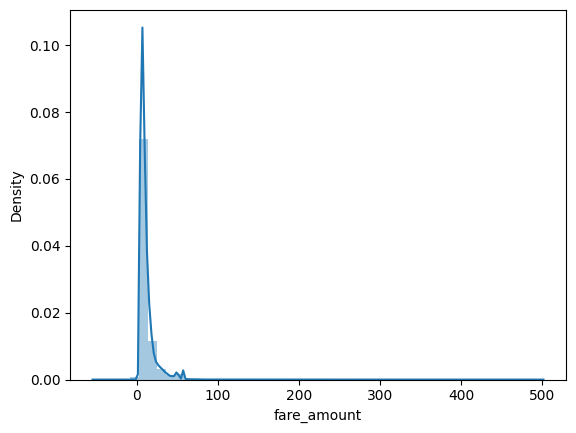

In [26]:
sns.distplot(ny_data['fare_amount'])

In [27]:
ny_data['fare_amount'].skew()

4.237450399276987

<ipython-input-28-0d7a759ac8d1>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ny_data['fare_amount'])


<Axes: xlabel='fare_amount', ylabel='Density'>

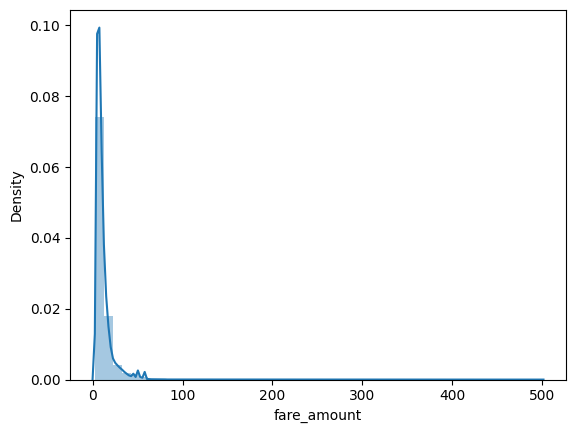

In [28]:
#removing the instances which has fare_ammount less than 1
ny_data = ny_data[ny_data['fare_amount'] > 1]
sns.distplot(ny_data['fare_amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x790a15fb0790>,
 'caps': [<matplotlib.lines.Line2D at 0x790a15fb0cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x790a15fb04f0>],
 'medians': [<matplotlib.lines.Line2D at 0x790a15fb1210>],
 'fliers': [<matplotlib.lines.Line2D at 0x790a15fb14b0>],
 'means': []}

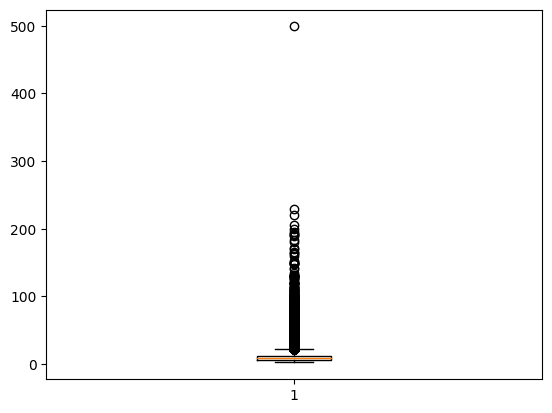

In [29]:
#outliers
plt.boxplot(ny_data['fare_amount'])

**Removing Outliers in 'fare_amount' Using Inter Quantile Range Technique**




In [30]:
ny_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,week_day,hour,Distance
count,195771.000000,195771.000000,195771.000000,195771.000000,195771.000000,195771.000000,195771.000000,195771.000000,195771.000000,195771.000000,195771.000000,195771.000000
mean,11.343885,-73.975167,40.751040,-73.974205,40.751339,1.684877,2011.739165,6.283816,15.702167,3.048194,13.490241,3.333091
std,9.792636,0.040602,0.029891,0.039609,0.033315,1.387775,1.859466,3.440592,8.689092,1.947199,6.514682,3.835744
min,2.500000,-77.316665,40.492457,-75.423067,40.486242,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992272,40.736463,-73.991597,40.735337,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.256412
50%,8.500000,-73.982110,40.753316,-73.980538,40.753753,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.157186
75%,12.500000,-73.968361,40.767555,-73.965380,40.768337,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.906603
max,499.000000,-72.750302,42.223633,-72.759090,42.273158,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,286.192106


In [31]:
Q1 = ny_data['fare_amount'].quantile(0.25)
Q3 = ny_data['fare_amount'].quantile(0.75)

print(f'25% of Values are below{Q1}')
print(f'75% of Values are below{Q3}')

IQR = Q3-Q1
print("IQR Value:", IQR)

25% of Values are below6.0
75% of Values are below12.5
IQR Value: 6.5


In [32]:
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print('Lower Limit:',lower_limit)
print('Upper Limit:',upper_limit)

Lower Limit: -3.75
Upper Limit: 22.25


In [33]:
fare_amount_outliers = ny_data[(ny_data['fare_amount']<lower_limit) | (ny_data['fare_amount']>upper_limit)]
fare_amount_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16744 entries, 6 to 199997
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                16744 non-null  object 
 1   fare_amount        16744 non-null  float64
 2   pickup_longitude   16744 non-null  float64
 3   pickup_latitude    16744 non-null  float64
 4   dropoff_longitude  16744 non-null  float64
 5   dropoff_latitude   16744 non-null  float64
 6   passenger_count    16744 non-null  int64  
 7   year               16744 non-null  int64  
 8   Month              16744 non-null  int64  
 9   Day                16744 non-null  int64  
 10  week_day           16744 non-null  int64  
 11  hour               16744 non-null  int64  
 12  time_of_day        16744 non-null  object 
 13  Distance           16744 non-null  float64
dtypes: float64(6), int64(6), object(2)
memory usage: 1.9+ MB


In [34]:
ny_data = ny_data[(ny_data['fare_amount']>lower_limit) & (ny_data['fare_amount']<upper_limit)]

<ipython-input-35-3897524a5eb0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ny_data['fare_amount'])


<Axes: xlabel='fare_amount', ylabel='Density'>

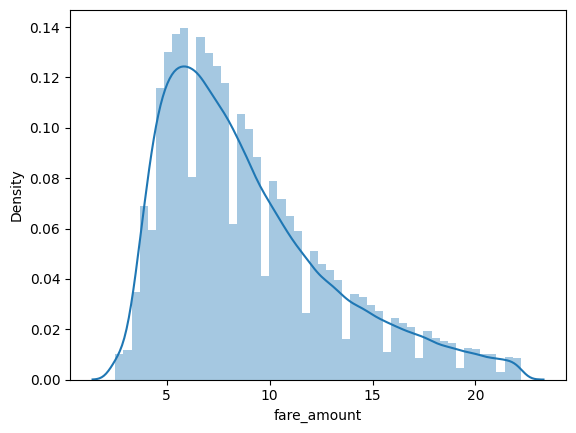

In [35]:
sns.distplot(ny_data['fare_amount'])

In [36]:
skewness = ny_data['fare_amount'].skew()
print(f'Skewness after removing the outlers:{skewness}')

Skewness after removing the outlers:1.0001586500833513


In [37]:
ny_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179027 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                179027 non-null  object 
 1   fare_amount        179027 non-null  float64
 2   pickup_longitude   179027 non-null  float64
 3   pickup_latitude    179027 non-null  float64
 4   dropoff_longitude  179027 non-null  float64
 5   dropoff_latitude   179027 non-null  float64
 6   passenger_count    179027 non-null  int64  
 7   year               179027 non-null  int64  
 8   Month              179027 non-null  int64  
 9   Day                179027 non-null  int64  
 10  week_day           179027 non-null  int64  
 11  hour               179027 non-null  int64  
 12  time_of_day        179027 non-null  object 
 13  Distance           179027 non-null  float64
dtypes: float64(6), int64(6), object(2)
memory usage: 20.5+ MB


**Removing Outliers in Distance**

<ipython-input-38-cb737583b825>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ny_data['Distance'])


<Axes: xlabel='Distance', ylabel='Density'>

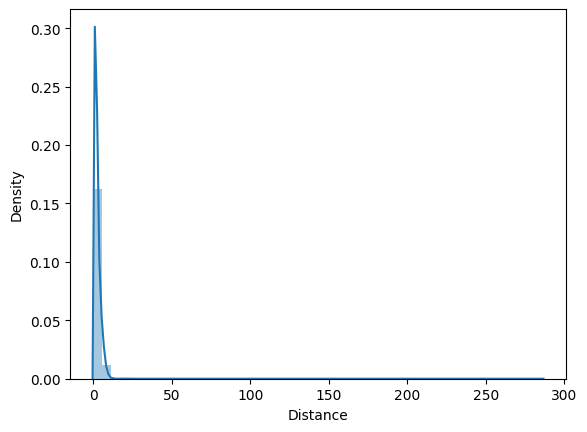

In [38]:
sns.distplot(ny_data['Distance'])

{'whiskers': [<matplotlib.lines.Line2D at 0x790a15d7b010>,
 'caps': [<matplotlib.lines.Line2D at 0x790a15d7b550>,
 'boxes': [<matplotlib.lines.Line2D at 0x790a15d7ad70>],
 'medians': [<matplotlib.lines.Line2D at 0x790a15d7ba90>],
 'fliers': [<matplotlib.lines.Line2D at 0x790a15d7bd30>],
 'means': []}

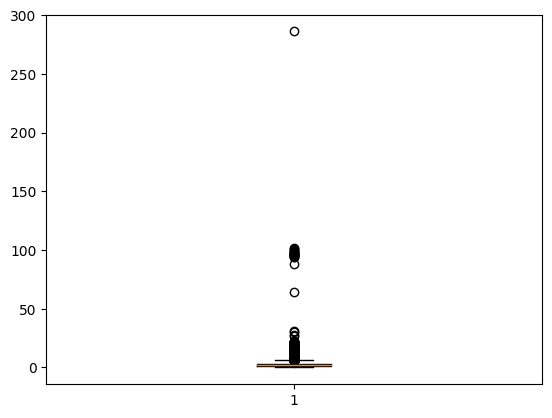

In [39]:
plt.boxplot(ny_data['Distance'])

In [40]:
ny_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,week_day,hour,Distance
count,179027.000000,179027.000000,179027.000000,179027.000000,179027.000000,179027.000000,179027.000000,179027.000000,179027.000000,179027.000000,179027.000000,179027.000000
mean,8.941019,-73.979706,40.752239,-73.977982,40.752482,1.681791,2011.700040,6.264871,15.705542,3.048920,13.531897,2.524192
std,4.138530,0.029852,0.027052,0.029427,0.029223,1.393680,1.855521,3.444252,8.686348,1.943052,6.510588,2.209139
min,2.500000,-77.316665,40.492457,-75.375315,40.486242,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,5.700000,-73.992595,40.737140,-73.991857,40.736904,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.199634
50%,8.000000,-73.982510,40.753225,-73.981233,40.753862,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,1.990211
75%,11.000000,-73.970289,40.766896,-73.967977,40.767822,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.306687
max,22.200000,-72.750302,42.223633,-72.759090,42.273158,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,286.192106


In [41]:
sample = ny_data[ny_data['Distance'] <=0]
sample

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,week_day,hour,time_of_day,Distance
5,2011-02-12 02:27:09.0000006,4.9,-73.969019,40.755910,-73.969019,40.755910,1,2011,2,12,5,2,Night,0.0
166,2014-01-22 21:01:18.0000004,4.5,-73.992937,40.757780,-73.992937,40.757780,1,2014,1,22,2,21,Night,0.0
361,2009-08-24 17:25:00.00000056,10.1,-73.928705,40.753475,-73.928705,40.753475,1,2009,8,24,0,17,Afternoon,0.0
467,2011-01-10 10:14:00.00000069,4.9,-74.002718,40.760635,-74.002718,40.760635,2,2011,1,10,0,10,Morning,0.0
733,2010-05-01 13:06:00.00000042,6.9,-73.992287,40.721032,-73.992287,40.721032,5,2010,5,1,5,13,Afternoon,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199432,2011-10-24 16:14:06.0000002,8.5,-74.009728,40.720796,-74.009728,40.720796,1,2011,10,24,0,16,Afternoon,0.0
199448,2010-07-24 21:16:00.00000062,5.7,-73.924907,40.745833,-73.924907,40.745833,3,2010,7,24,5,21,Night,0.0
199612,2013-02-17 11:27:00.00000040,4.5,-73.969717,40.765832,-73.969717,40.765832,3,2013,2,17,6,11,Morning,0.0
199647,2009-06-07 02:07:26.0000001,2.5,-73.956623,40.771633,-73.956623,40.771633,1,2009,6,7,6,2,Night,0.0


In the above result the latitude and longitudes of the pickup and drop off points are same which resulted 0 in distance. That may be the cancelled ride and the fare_ammount may be considered as Cancellation fee.
Insight: We can calculate the Total cancellation charges earned by the uber/uber drivers.

In [42]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1838 entries, 5 to 199917
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                1838 non-null   object 
 1   fare_amount        1838 non-null   float64
 2   pickup_longitude   1838 non-null   float64
 3   pickup_latitude    1838 non-null   float64
 4   dropoff_longitude  1838 non-null   float64
 5   dropoff_latitude   1838 non-null   float64
 6   passenger_count    1838 non-null   int64  
 7   year               1838 non-null   int64  
 8   Month              1838 non-null   int64  
 9   Day                1838 non-null   int64  
 10  week_day           1838 non-null   int64  
 11  hour               1838 non-null   int64  
 12  time_of_day        1838 non-null   object 
 13  Distance           1838 non-null   float64
dtypes: float64(6), int64(6), object(2)
memory usage: 215.4+ KB


<ipython-input-43-6fc3a1fb2d73>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ny_data['Distance'])


<Axes: xlabel='Distance', ylabel='Density'>

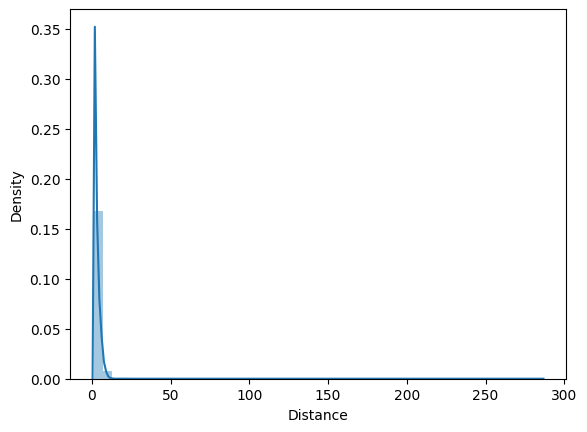

In [43]:
ny_data = ny_data[ny_data['Distance'] >= 1]
sns.distplot(ny_data['Distance'])

In [44]:
ny_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,Month,Day,week_day,hour,Distance
count,147371.000000,147371.000000,147371.000000,147371.000000,147371.000000,147371.000000,147371.000000,147371.000000,147371.000000,147371.000000,147371.000000,147371.000000
mean,9.742473,-73.980390,40.751895,-73.978318,40.752174,1.682991,2011.702764,6.275617,15.725957,3.066098,13.549715,2.926435
std,4.018381,0.025640,0.024865,0.025069,0.027679,1.305221,1.850227,3.434770,8.681098,1.948205,6.594589,2.235342
min,2.500000,-77.316665,40.492457,-75.375315,40.486242,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,1.000047
25%,6.500000,-73.992915,40.736664,-73.992012,40.736173,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.590443
50%,8.900000,-73.982714,40.752747,-73.981182,40.753584,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.350912
75%,12.000000,-73.970636,40.766907,-73.967809,40.768096,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.697998
max,22.200000,-72.750302,42.223633,-72.759090,42.273158,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,286.192106


In [45]:
Q1 = ny_data['Distance'].quantile(0.25)
Q3 = ny_data['Distance'].quantile(0.75)
print(Q1)
print(Q3)
IQR = Q3-Q1
print("IQR Value:", IQR)
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print('Lower Limit:',lower_limit)
print('Upper Limit:',upper_limit)

1.5904432383586893
3.6979979711703814
IQR Value: 2.107554732811692
Lower Limit: -1.5708888608588487
Upper Limit: 6.859330070387919


In [46]:
distance_outliers = ny_data[(ny_data['Distance']<lower_limit) | (ny_data['Distance']>upper_limit)]
distance_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6026 entries, 52 to 199961
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                6026 non-null   object 
 1   fare_amount        6026 non-null   float64
 2   pickup_longitude   6026 non-null   float64
 3   pickup_latitude    6026 non-null   float64
 4   dropoff_longitude  6026 non-null   float64
 5   dropoff_latitude   6026 non-null   float64
 6   passenger_count    6026 non-null   int64  
 7   year               6026 non-null   int64  
 8   Month              6026 non-null   int64  
 9   Day                6026 non-null   int64  
 10  week_day           6026 non-null   int64  
 11  hour               6026 non-null   int64  
 12  time_of_day        6026 non-null   object 
 13  Distance           6026 non-null   float64
dtypes: float64(6), int64(6), object(2)
memory usage: 706.2+ KB


In [47]:
ny_data = ny_data[(ny_data['Distance']>lower_limit) & (ny_data['Distance']<upper_limit)]

<ipython-input-48-cb737583b825>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ny_data['Distance'])


<Axes: xlabel='Distance', ylabel='Density'>

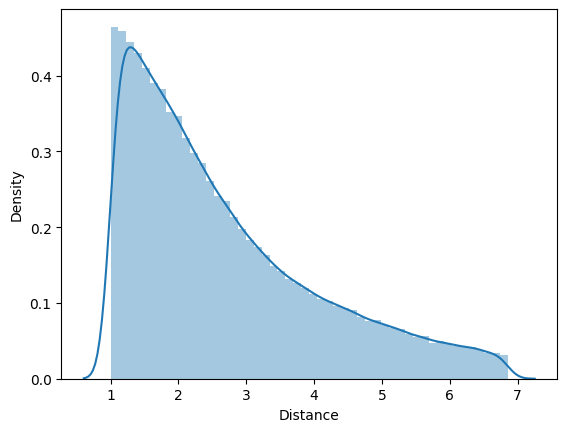

In [48]:
sns.distplot(ny_data['Distance'])

In [49]:
ny_data['Distance'].skew()

1.0020080041203943

In [50]:
ny_data.columns

Index(['key', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'Month', 'Day', 'week_day', 'hour', 'time_of_day', 'Distance'],
      dtype='object')

In [51]:
#Converting Categorical Variables to Numerical Values
eval_data = ny_data.drop(columns=['key','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','passenger_count','Day','year'])

In [52]:
#encoding the categorical variabels
dummies = pd.get_dummies(eval_data['time_of_day'])
dummies

,Afternoon,Morning,Night
0,0,0,1
1,0,0,1
2,0,0,1
3,0,1,0
4,1,0,0
...,...,...,...
199993,0,0,1
199994,1,0,0
199996,0,0,1
199998,1,0,0


In [53]:
eval_data = pd.concat([eval_data,dummies], axis = 'columns')

In [54]:
eval_data.head()

,fare_amount,Month,week_day,hour,time_of_day,Distance,Afternoon,Morning,Night
0,7.5,5,3,19,Night,1.681111,0,0,1
1,7.7,7,4,20,Night,2.454363,0,0,1
2,12.9,8,0,21,Night,5.039603,0,0,1
3,5.3,6,4,8,Morning,1.661442,0,1,0
4,16.0,8,3,17,Afternoon,4.483730,1,0,0


**Exploratory Data Analsys**

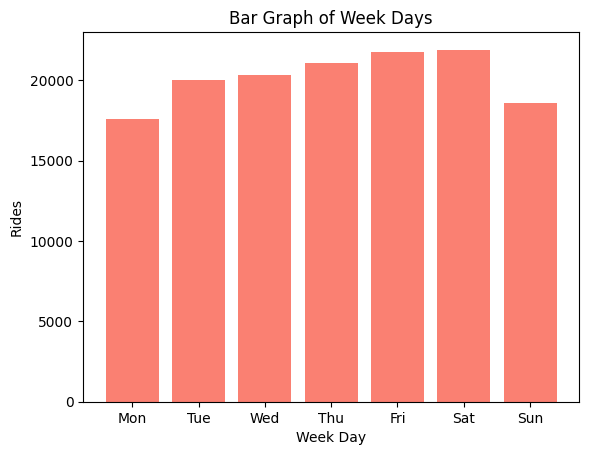

In [55]:
weekday_counts = eval_data['week_day'].value_counts().sort_index()
plt.bar(weekday_counts.index, weekday_counts, color='salmon', alpha = 1)
plt.xlabel('Week Day')
plt.ylabel('Rides')
plt.title('Bar Graph of Week Days')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

Text(0.5, 1.0, 'Most Rides were taken During')

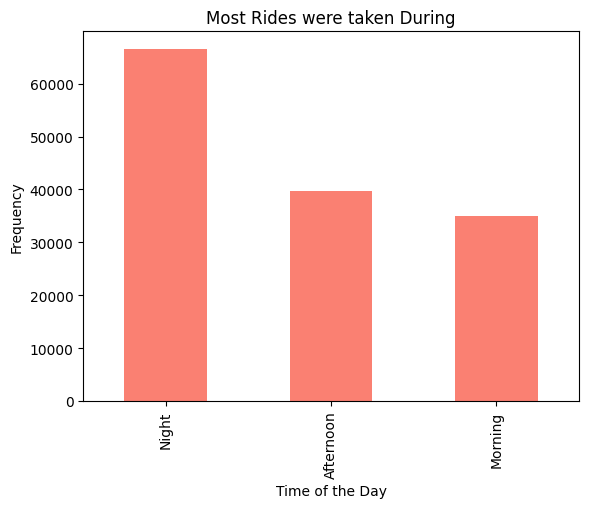

In [56]:
#Most of the rides are taken during ['morning','Afternoon','Evening/Night']
time_day_counts = eval_data['time_of_day'].value_counts()
time_day_counts.plot(kind = 'bar', color = 'salmon')
plt.xlabel('Time of the Day')
plt.ylabel('Frequency')
plt.title('Most Rides were taken During')

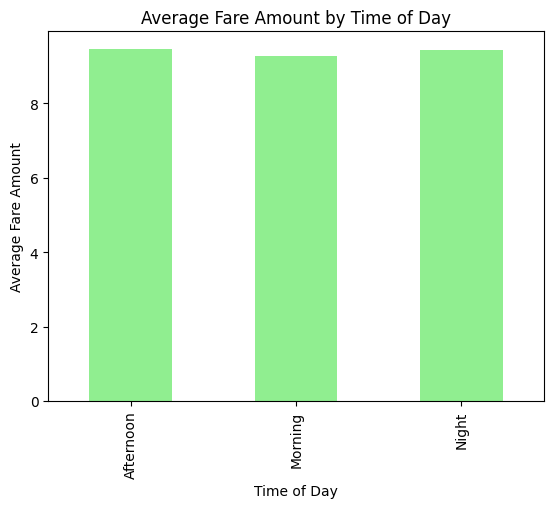

In [63]:
avg_fare_per_time = eval_data.groupby('time_of_day')['fare_amount'].mean()
avg_fare_per_time.plot(kind='bar', color='lightgreen')
plt.xlabel('Time of Day')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Time of Day')
plt.show()

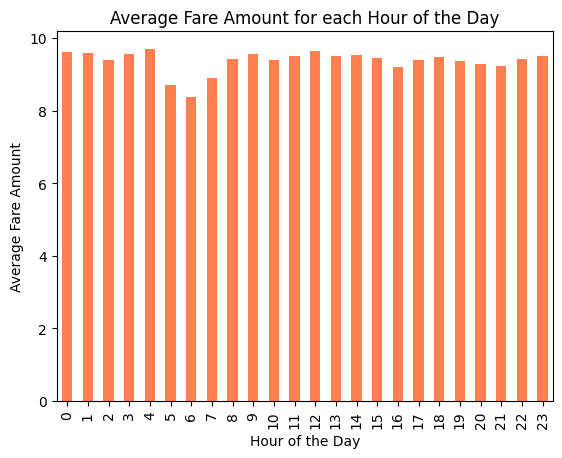

In [58]:
avg_fare_per_hour = eval_data.groupby('hour')['fare_amount'].mean()
avg_fare_per_hour.plot(kind='bar', color='coral')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount for each Hour of the Day')
plt.show()

In [183]:
eval_data = eval_data.drop(columns=['time_of_day'])

In [184]:
#Need to add few visualizations here

<Axes: >

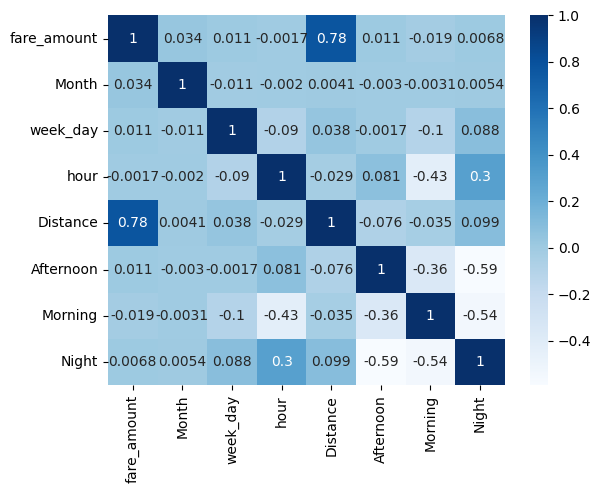

In [185]:
sns.heatmap(eval_data.corr(), cmap="Blues", annot=True)

**Model Building**

In [186]:
#splitting the data into X and Y
X = eval_data.drop('fare_amount', axis = 1)
y = eval_data['fare_amount']
X.shape, y.shape

((141345, 7), (141345,))

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

print("Training set shape : ",X_train.shape, y_train.shape)
print("Testing set shape : ", X_test.shape, y_test.shape)

Training set shape :  (113076, 7) (113076,)
Testing set shape :  (28269, 7) (28269,)


In [196]:
#Standard Scalar : adjusting the range of values of each feature to a standard range
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Linear Regression:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_scaled, y_train)
y_pred = linear_regression_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(math.sqrt(mse))
print(r2)

2.2930510017131813
0.6109606693634764


In [ ]:
#Linear Regression using only independent variable
simple_X = eval_data[['Distance']]
simple_y = eval_data['fare_amount']
A_train, A_test, l_train,l_test =  train_test_split(simple_X,simple_y,test_size = 0.2,random_state=42)
simple_linear_regression = LinearRegression()
simple_linear_regression.fit(simple_X,simple_y)

#predictions
y_predictions = simple_linear_regression.predict(A_test)
RMSE = math.sqrt(mean_squared_error(l_test,y_predictions))
print(f'RMSE Value for Simple Linear Regression:{RMSE}')
r2 = r2_score(l_test,y_predictions)
print(f'r2 Score : {r2}')

RMSE Value for Simple Linear Regression:2.3184259735504846
r2 Score : 0.6023027867316824


In [197]:
#Support Vector Regression:#kernel : rbf useful for non linearity radial basis function
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test_scaled)

# Evaluate the model
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')
r2 = r2_score(y_test,y_pred)
print(r2)

Root Mean Squared Error (RMSE): 2.2598219220829048
0.62215427293152


In [ ]:
#KNN Regression Model
knn_model = KNeighborsRegressor(n_neighbors=500)
knn_model.fit(X_train_scaled,y_train)
y_predictions = knn_model.predict(X_test_scaled)

rmse = math.sqrt(mean_squared_error(y_test,y_predictions))
print(f'Root Mean Squared Error (RMSE):{rmse}')
r2 = r2_score(y_test,y_predictions)
print(f'r2 Score:{r2}')

Root Mean Squared Error (RMSE):2.264054871868564
r2 Score:0.620737435683358


**Hyperparameter Tuning with KNeighborsRegressor**


In [ ]:
grid_parameters = {
    'n_neighbors' : np.arange(100,500,10),'weights': ['uniform','distance'],'p': [1,2]
}

In [ ]:
grid_search = GridSearchCV(knn_model, param_grid = grid_parameters, cv = 5, scoring ='neg_mean_squared_error')
grid_search.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(n_neighbors=500),
             param_grid={'n_neighbors': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([0.23309283, 0.15936956, 0.15083289, 0.14855328, 0.15097919,
        0.1552392 , 0.15143814, 0.15177946, 0.15039144, 0.16807985,
        0.1549623 , 0.15204096, 0.14748988, 0.1305315 , 0.1469974 ,
        0.1314177 , 0.14646664, 0.13936939, 0.16551409, 0.14379973,
        0.14717584, 0.14697247, 0.14981885, 0.15044489, 0.17315316,
        0.17218685, 0.15067773, 0.15489798, 0.13346496, 0.16369309,
        0.14565792, 0.17066083, 0.15465055, 0.15489044, 0.15083394,
        0.153617  , 0.15217252, 0.15571899, 0.15409708, 0.13339882,
        0.15085344, 0.16547127, 0.15108919, 0.15051932, 0.15120788,
        0.15077634, 0.13036141, 0.13087287, 0.15327954, 0.13786292,
        0.13588276, 0.18548722, 0.18188152, 0.1655623 , 0.15433221,
        0.17928863, 0.1775702 , 0.16470008, 0.18488293, 0.16309271,
        0.17047124, 0.16762409, 0.14443011, 0.18515744, 0.15340805,
        0.145469  , 0.15373788, 0.17054925, 0.13995657, 0.16916986,
        0.15114923, 0.15889778,

In [ ]:
grid_cv_results = pd.DataFrame(grid_search.cv_results_)
grid_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.233093,0.121850,5.889092,2.093102,100,1,uniform,"{'n_neighbors': 100, 'p': 1, 'weights': 'unifo...",-5.127465,-5.075651,-5.045779,-5.012994,-4.939463,-5.040271,0.062914,4
1,0.159370,0.032173,3.937377,0.614124,100,1,distance,"{'n_neighbors': 100, 'p': 1, 'weights': 'dista...",-5.501686,-5.428232,-5.385914,-5.401486,-5.277989,-5.399062,0.072416,160
2,0.150833,0.035416,2.600697,0.289881,100,2,uniform,"{'n_neighbors': 100, 'p': 2, 'weights': 'unifo...",-5.120992,-5.074442,-5.039594,-5.014219,-4.936425,-5.037134,0.061802,1
3,0.148553,0.033178,2.699256,0.593365,100,2,distance,"{'n_neighbors': 100, 'p': 2, 'weights': 'dista...",-5.437446,-5.373709,-5.326365,-5.341051,-5.216520,-5.339018,0.072196,155
4,0.150979,0.036012,3.695823,0.337485,110,1,uniform,"{'n_neighbors': 110, 'p': 1, 'weights': 'unifo...",-5.128163,-5.076858,-5.047335,-5.012920,-4.938285,-5.040712,0.063658,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.146366,0.033355,7.785164,0.582758,480,2,distance,"{'n_neighbors': 480, 'p': 2, 'weights': 'dista...",-5.292144,-5.243226,-5.200821,-5.182528,-5.085899,-5.200924,0.068818,85
156,0.168503,0.045565,9.404483,0.351790,490,1,uniform,"{'n_neighbors': 490, 'p': 1, 'weights': 'unifo...",-5.256286,-5.214356,-5.180524,-5.138654,-5.065954,-5.171155,0.065307,80
157,0.149125,0.035352,9.673072,0.675236,490,1,distance,"{'n_neighbors': 490, 'p': 1, 'weights': 'dista...",-5.349293,-5.293505,-5.248680,-5.236199,-5.131263,-5.251788,0.072148,122
158,0.133357,0.004164,7.506445,0.586753,490,2,uniform,"{'n_neighbors': 490, 'p': 2, 'weights': 'unifo...",-5.212499,-5.175243,-5.143983,-5.101713,-5.032582,-5.133204,0.062109,70


In [ ]:
#Getting the best Parameters
best_params = grid_search.best_params_
print(f'Best Parameters:{best_params}')

Best Parameters:{'n_neighbors': 100, 'p': 2, 'weights': 'uniform'}


In [ ]:
#Getting the best model for predictions
best_model = grid_search.best_estimator_

#Predicting with best model
y_pred_b = best_model.predict(X_test_scaled)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_b))
print(f'Root Mean Squared Error from the best model(RMSE): {rmse}')
r2 = r2_score(y_test,y_pred_b)
print(f'r2 Score from the best model:{r2}')

Root Mean Squared Error from the best model(RMSE): 2.241603197423947
r2 Score:0.6282221124083082


In [ ]:
#Random Forest Model Implementation
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)
training_r2 = rf_model.score(X_train, y_train)
print(f'Training R-squared Score: {training_r2}')
y_predictions = rf_model.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')
r2 = r2_score(y_test,y_predictions)
print(f'r2 Score : {r2}')

Training R-squared Score: 0.9415043880810372
Root Mean Squared Error (RMSE): 2.3867543279909036
r2 Score : 0.5785155873678378


HyperParameter Tuning for Random Forest Model

In [ ]:
parameters_grid = {
    'n_estimators': [100,200,400,500,600],
    'max_features' :[1],
    'max_depth': [10,20],
    'min_samples_split':[10,25], #for below both values: setting higher values can avoid overfitting
    'min_samples_leaf': [10,25] #minimum number of samples required to be in a leaf node
}

rf_model = RandomForestRegressor()
G_S = GridSearchCV(rf_model,param_grid = parameters_grid, scoring = 'neg_mean_squared_error', cv = 5)
G_S.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20], 'max_features': [1],
                         'min_samples_leaf': [10, 25],
                         'min_samples_split': [10, 25],
                         'n_estimators': [100, 200, 400, 500, 600]},
             scoring='neg_mean_squared_error')

In [ ]:
G_S_results = pd.DataFrame(G_S.cv_results_)
print(G_S_results)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        5.071468      1.625746         0.277576        0.027523   
1        8.565981      0.408291         0.540560        0.049592   
2       17.409114      0.567906         1.042924        0.068970   
3       21.752208      0.556571         1.295520        0.057103   
4       25.678482      0.506065         1.635510        0.127541   
5        4.466836      0.706910         0.251617        0.003200   
6        8.549580      0.542644         0.539534        0.048221   
7       17.415400      0.515910         1.077451        0.097543   
8       21.657413      0.714336         1.300679        0.088368   
9       25.635517      0.431103         1.656867        0.129499   
10       4.347946      0.762679         0.256067        0.019628   
11       8.380246      0.482283         0.532411        0.047276   
12      16.877294      0.487430         1.019892        0.068386   
13      21.279255      0.631202         1.265940

In [ ]:
best_parameters = G_S.best_params_
print(f'Best Parameters:{best_parameters}')

Best Parameters:{'max_depth': 20, 'max_features': 1, 'min_samples_leaf': 10, 'min_samples_split': 25, 'n_estimators': 500}


In [ ]:
best_rf_model = G_S.best_estimator_
y_predictions = best_rf_model.predict(X_test)

# Evaluate the model
rmse = math.sqrt(mean_squared_error(y_test, y_predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'rs_score{r2_score(y_test,y_predictions)}')

Root Mean Squared Error (RMSE): 2.2450894142920435
rs_score0.6270648101593477


**Gradient Boosting Techniques (LightGBM)**

In [ ]:
#Gradient Boosting Techniques (using the LightGBM:)
#Converting the data into lgbm format
train_data = lgb.Dataset(X_train, label = y_train)
test_data = lgb.Dataset(X_test,label = y_test)

params = {
    'objective':'regression',
    'metric':'rmse',
    'boosting_type':'gbdt',
    'num_leaves':30,
    'learning_rate':0.05,
    'feature_fraction:':0.9
}

num_round = 1000
callbacks = [lgb.early_stopping(stopping_rounds=50)]
lgb_model= lgb.train(params,train_data,num_round,valid_sets=[test_data],callbacks=callbacks)
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

[LightGBM] [Warning] Unknown parameter: feature_fraction:
[LightGBM] [Warning] Unknown parameter: feature_fraction:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 113076, number of used features: 7
[LightGBM] [Warning] Unknown parameter: feature_fraction:
[LightGBM] [Info] Start training from score 9.400410
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	valid_0's rmse: 2.22374


In [ ]:
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
print(f'RMSE Value for LGBM:{rmse}')
r2 = r2_score(y_test,y_pred)
print(f'r2 Score : {r2}')

RMSE Value for LGBM:2.223740421791665
r2 Score : 0.6341237142831585


In [198]:
models = ['Linear Regression','Simple Linear Regression','SVM','KNN',"Random Forest","LightGBM"]
r2_scores = [0.6109606693634764,0.6023027867316824,0.62215427293152,0.6282221124083082,0.6270648101593477,0.6341237142831585]
rmse_score = [2.2930510017131813,2.3184259735504846,2.2598219220829048, 2.241603197423947,2.2450894142920435,2.223740421791665]

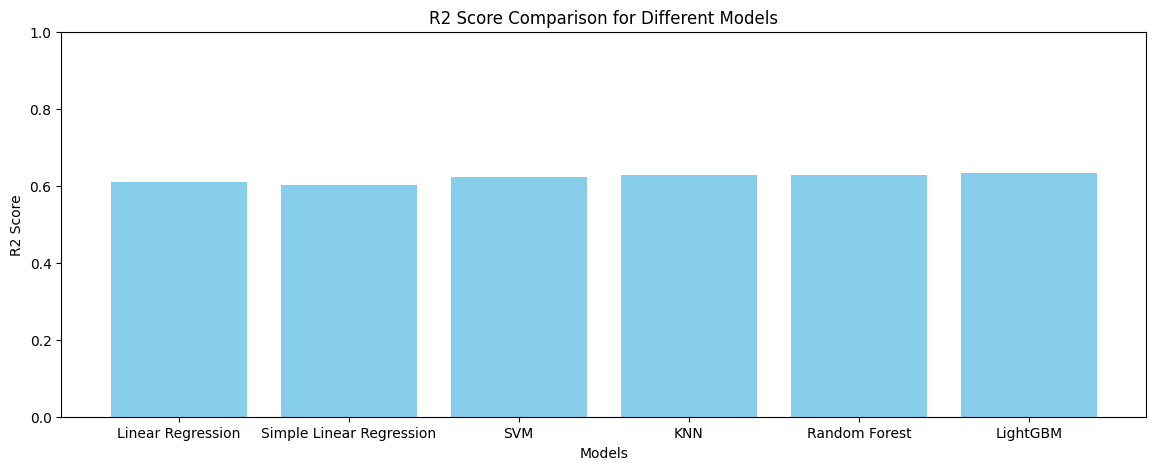

In [206]:
plt.figure(figsize=(14, 5))
plt.bar(models, r2_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Score Comparison for Different Models')
plt.ylim(0, 1)  # Set y-axis limit to range [0, 1]
plt.show()

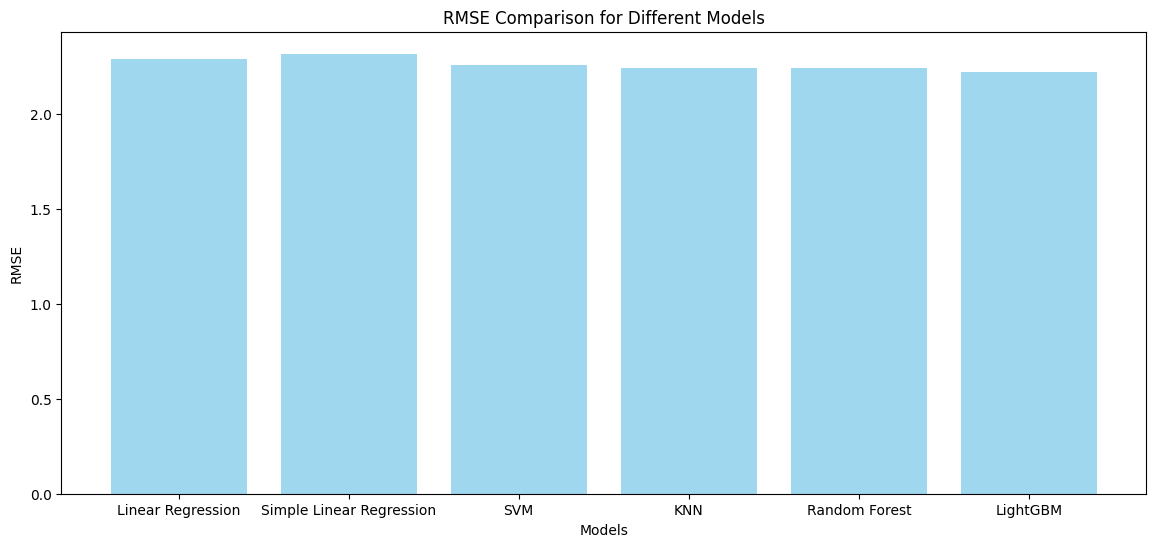

In [209]:
plt.figure(figsize=(14, 6))
plt.bar(models, rmse_score, color='skyblue', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison for Different Models')
plt.show()